<a href="https://colab.research.google.com/github/tirthpatel1111/Tops/blob/main/Nueral%20network%20and%20deep%20learning/Assignment/avengers_face_detaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle # creating .kaggle folder to store kaggle file
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d rawatjitesh/avengers-face-recognition

Dataset URL: https://www.kaggle.com/datasets/rawatjitesh/avengers-face-recognition
License(s): copyright-authors
  0% 0.00/54.5M [00:00<?, ?B/s]
100% 54.5M/54.5M [00:00<00:00, 1.63GB/s]


In [ ]:
!unzip /content/avengers-face-recognition.zip

Archive:  /content/avengers-face-recognition.zip
  inflating: cropped_images/chris_evans/chris_evans1.png  
  inflating: cropped_images/chris_evans/chris_evans10.png  
  inflating: cropped_images/chris_evans/chris_evans11.png  
  inflating: cropped_images/chris_evans/chris_evans12.png  
  inflating: cropped_images/chris_evans/chris_evans13.png  
  inflating: cropped_images/chris_evans/chris_evans14.png  
  inflating: cropped_images/chris_evans/chris_evans15.png  
  inflating: cropped_images/chris_evans/chris_evans16.png  
  inflating: cropped_images/chris_evans/chris_evans17.png  
  inflating: cropped_images/chris_evans/chris_evans18.png  
  inflating: cropped_images/chris_evans/chris_evans19.png  
  inflating: cropped_images/chris_evans/chris_evans2.png  
  inflating: cropped_images/chris_evans/chris_evans20.png  
  inflating: cropped_images/chris_evans/chris_evans21.png  
  inflating: cropped_images/chris_evans/chris_evans22.png  
  inflating: cropped_images/chris_evans/chris_evans23

In [ ]:
import os
import numpy as np
import struct
import pickle
from array import array
%matplotlib inline
import random
import matplotlib.pyplot as plt

from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from PIL import Image
from os.path  import join
import csv
import glob
import imageio
from glob import glob
import shutil
import json
from sklearn.impute import KNNImputer,SimpleImputer
import pandas as pd
import torch
from torch import nn, optim
from torch.autograd import Variable
import torchvision.models as models
import torchvision.utils as vutils
from torchvision.io import read_image
from torchvision.transforms.functional import rgb_to_grayscale
from sklearn.model_selection import train_test_split
import re
import math
import random

from collections import Counter

In [ ]:
from keras.preprocessing import image

In [ ]:
def plot_img_from_dir(dir_path, class_name, num_images=9):
    img_file_names = os.listdir(dir_path)


    if len(img_file_names) < num_images:
        print(f"There are only {len(img_file_names)} images — displaying all of them.")
        num_images = len(img_file_names)
s
    selected_images = random.sample(img_file_names, num_images)


    cols = int(num_images ** 0.5)
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6, 6))
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        img = imageio.imread(os.path.join(dir_path, image_file))
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-1750611548.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(os.path.join(dir_path, image_file))


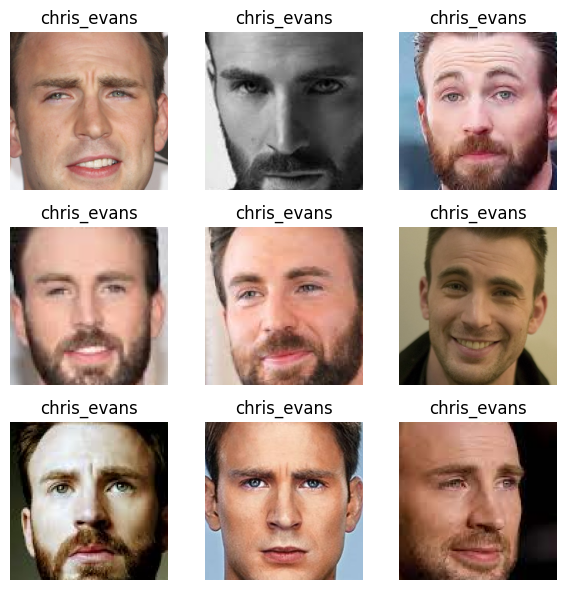

In [ ]:
plot_img_from_dir("/content/cropped_images/chris_evans","chris_evans")

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = Path(root_dir)
        # print(self.root_dir)
        self.transform = transform


        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        # print(self.classes)
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        # print(self.class_to_idx)
        self.samples = []
        for cls_name in self.classes:
            cls_dir = self.root_dir / cls_name
            for img_file in cls_dir.iterdir():
                if img_file.is_file():

                    self.samples.append((img_file, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
data=FaceDataset("/content/cropped_images",transform=transform)

In [ ]:
val_frac=0.2
val_size=int(len(data)*val_frac)
train_size=len(data)-val_size
train_data,val_data=random_split(data,[train_size,val_size])

In [ ]:
train_loader=DataLoader(train_data,batch_size=32,pin_memory=True,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,pin_memory=True,shuffle=True)

In [ ]:
def compute_accuracy(output, label):
    _, predicted = torch.max(output.data, 1)


    total_samples = label.size(0)


    correct_predictions = (predicted == label).sum().item()

    return correct_predictions, total_samples

In [ ]:
def train_one_epoch(model, criterion, optimizer, data_loader, device):
    model.train()
    total_loss=0.0
    total_correct = 0
    total_samples = 0
    for data,label in data_loader:
        data,label=data.to(device),label.to(device)
        optimizer.zero_grad()
        output=model(data)
        loss=criterion(output,label)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()*data.size(0)
        correct, num_samples = compute_accuracy(output, label)
        total_correct += correct
        total_samples += num_samples

    avg_loss=total_loss/len(data_loader.dataset)
    avg_acc = total_correct / total_samples
    return avg_loss,avg_acc

In [ ]:
def eval_one_epoch(model, criterion, optimizer, data_loader, device):
    model.eval()
    total_loss=0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
      for data,label in data_loader:
          data,label=data.to(device),label.to(device)
          optimizer.zero_grad()
          output=model(data)
          loss=criterion(output,label)

          total_loss+=loss.item()*data.size(0)
          correct, num_samples = compute_accuracy(output, label)
          total_correct += correct
          total_samples += num_samples
    avg_loss=total_loss/len(data_loader.dataset)
    avg_acc = total_correct / total_samples
    return avg_loss,avg_acc

In [ ]:
class MultiClassClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in model.backbone.layer1.parameters():
             param.requires_grad = False

        for param in self.backbone.layer4.parameters():
            param.requires_grad = True
        in_features = self.backbone.fc.in_features

        self.backbone.fc = nn.Sequential(
              nn.Dropout(0.4),
                nn.Linear(in_features, num_classes)
                  )

    def forward(self, x):
        return self.backbone(x)

In [ ]:
model=MultiClassClassifier(num_classes=5)

In [ ]:
def run_training(model, train_loader, val_loader, epochs=30, lr=1e-4, device='cpu'):
    model = model.to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    for e in range(epochs):
        train_loss, train_acc = train_one_epoch(model, criterion, optimizer, train_loader, device)
        val_loss, val_acc = eval_one_epoch(model, criterion, val_loader, device)
        scheduler.step()
        print(f"Epoch {e+1}/{epochs} | train_acc={train_acc:.4f} | train_loss={train_loss:.4f} | "
              f"val_acc={val_acc:.4f} | val_loss={val_loss:.4f}")

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(f"Using device: {device}")

Using device: cuda


In [ ]:
run_tranning(model=model,device=device)

Epoch 1 / 30 |train_acc1.0000 | train_loss 0.0019| val_acc0.8889 |val_loss 0.2827
Epoch 2 / 30 |train_acc1.0000 | train_loss 0.0035| val_acc0.9444 |val_loss 0.1694
Epoch 3 / 30 |train_acc1.0000 | train_loss 0.0058| val_acc0.9630 |val_loss 0.1310
Epoch 4 / 30 |train_acc1.0000 | train_loss 0.0021| val_acc0.9074 |val_loss 0.2818
Epoch 5 / 30 |train_acc1.0000 | train_loss 0.0019| val_acc0.8889 |val_loss 0.4030
Epoch 6 / 30 |train_acc0.9955 | train_loss 0.0140| val_acc0.8889 |val_loss 0.2844
Epoch 7 / 30 |train_acc1.0000 | train_loss 0.0007| val_acc0.7407 |val_loss 0.9466
Epoch 8 / 30 |train_acc0.9955 | train_loss 0.0720| val_acc0.8889 |val_loss 0.2170
Epoch 9 / 30 |train_acc1.0000 | train_loss 0.0019| val_acc0.8333 |val_loss 0.4982
Epoch 10 / 30 |train_acc0.9955 | train_loss 0.0151| val_acc0.8889 |val_loss 0.2993
Epoch 11 / 30 |train_acc1.0000 | train_loss 0.0019| val_acc0.9259 |val_loss 0.1734
Epoch 12 / 30 |train_acc1.0000 | train_loss 0.0014| val_acc0.9444 |val_loss 0.1400
Epoch 13 / 30